# Tasks

Build gates in Fluxonium via qutip exclusively

1. Approx fluxonium as a two level system as before

2. Define H0, drive (sx term), define initial state, tell qutip mesolve to return full solution (list of the wavefunctions at times defined bu times array (use qoptions)), evolve system using mesolve

Everything in lab frame 

3. Obtain the solution and then plot the population of state 0 and 1

4. Switch to multiple level fluxonium instead of the two level idea

In [582]:
import qutip as qt
import scqubits as scq
import numpy as np

## Approximate 2 level fluxonium

In [583]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 110) #default tutorial parameters

fluxonium

Fluxonium(**{'EJ': 8.9, 'EC': 2.5, 'EL': 0.5, 'flux': 0.33, 'cutoff': 110, 'truncated_dim': 6, 'id_str': 'Fluxonium_19', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})

In [584]:
Hamiltonian = qt.Qobj(fluxonium.hamiltonian())

Hamiltonian

Quantum object: dims=[[110], [110]], shape=(110, 110), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  2.463   2.853  -1.973 ...  -0.      0.      0.   ]
 [  2.853   2.836  -2.345 ...  -0.     -0.      0.   ]
 [ -1.973  -2.345   7.619 ...   0.     -0.     -0.   ]
 ...
 [ -0.     -0.      0.    ... 339.551  -0.044  -0.138]
 [  0.     -0.     -0.    ...  -0.044 342.923  -0.005]
 [  0.      0.     -0.    ...  -0.138  -0.005 346.222]]

In [585]:
fluxonium.eigenvals() # eigenvalues of the Hamiltonian

array([-1.727,  1.344,  8.494, 12.134, 13.343, 17.704])

## Definitions

### H0

In [586]:
evals, evecs = fluxonium.eigensys(evals_count=2)

omega_01 = evals[1] - evals[0]

omega_01

H_0 = 0.5 * omega_01 * qt.sigmaz()

H_0 # Hamiltonian in the rotating frame

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.536  0.   ]
 [ 0.    -1.536]]

### Drive term

In [587]:
A = 0.1
omega_d = omega_01

H = [H_0, [A * qt.sigmax(), 'cos(wd * t)']]
args = {'wd': omega_d}

### Initial State

In [588]:
psi0 = qt.basis(2, 0)

psi0 # 0 state of the qubit (two level system)

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

## Mesolve operations

In [589]:
times = np.linspace(0, 100, 1000) # time points for the simulation

proj_0 = qt.basis(2, 0) * qt.basis(2, 0).dag()

proj_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

In [590]:
proj_0 # projection operator onto the 0 state of the qubit (two level system)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [591]:
proj_1 # projection operator onto the 1 state of the qubit (two level system)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [592]:
result = qt.mesolve(
    H, psi0, times, [],
    [proj_0, proj_1],
    args=args
)


 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

## Plot population of 0 and 1

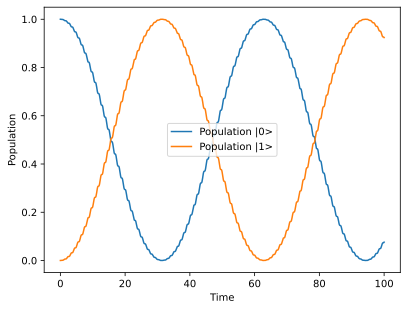

In [593]:
import matplotlib.pyplot as plt

plt.plot(times, result.expect[0], label='Population |0>')
plt.plot(times, result.expect[1], label='Population |1>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [594]:
from qutip import Options

options = Options(store_states=True, atol=1e-12); # change tolerance as needed

result = qt.mesolve(
    H, psi0, times, [],
    [proj_0, proj_1],
    args=args, options=options
)

states = result.states  # List of Qobj states at each time step

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

# Part 2 - Addition of Gamma

In [595]:
gamma = 0.05 * omega_01  #example value for gamma (small)

c_ops = [ (gamma ** 0.5) * qt.sigmam()] #collapse operator (decay)

In [596]:
result_gamma = qt.mesolve(
    H, psi0, times, c_ops,
    [proj_0, proj_1],
    args=args, options=options
)

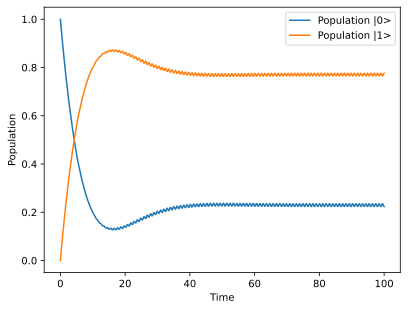

In [597]:
plt.plot(times, result_gamma.expect[0], label='Population |0>')
plt.plot(times, result_gamma.expect[1], label='Population |1>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

## Gamma w/out drive

In [598]:
result_nodrive = qt.mesolve(
    H_0, psi0, times, c_ops,
    [proj_0, proj_1], options=options
)

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

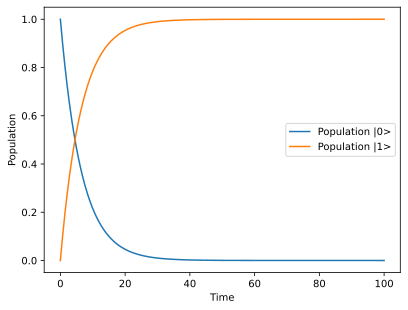

In [599]:
plt.plot(times, result_nodrive.expect[0], label='Population |0>')
plt.plot(times, result_nodrive.expect[1], label='Population |1>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

### Confirmation of slope of decay

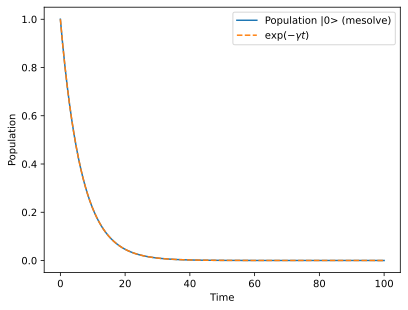

In [600]:
gamma_minus = gamma  # using the same gamma as above

exp_decay = np.exp(-gamma_minus * times)

plt.plot(times, result_nodrive.expect[0], label='Population |0> (mesolve)')
plt.plot(times, exp_decay, '--', label=r'$\exp(-\gamma t)$')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

### Non-trivial initial state

In [601]:
# the original

psi0 = qt.basis(2, 0)

psi0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

In [602]:
# test 1

# psi0_nontrivial = qt.Qobj((0.5 ** (1/2)) * (qt.basis(2, 0) + qt.basis(2, 1)))

# test 2
psi0_nontrivial = qt.Qobj((np.sqrt(3)/2) * (qt.basis(2, 0)) + (1/2) * qt.basis(2, 1))

psi0_nontrivial

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.866]
 [0.5  ]]

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

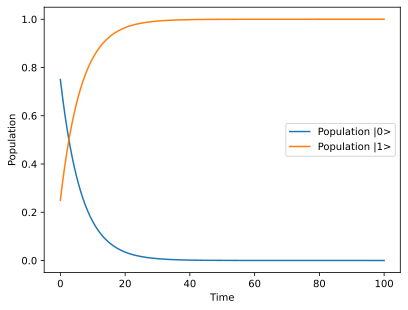

In [603]:
result_nodrive_nontrivial = qt.mesolve(
    H_0, psi0_nontrivial, times, c_ops,
    [proj_0, proj_1], options=options
)

plt.plot(times, result_nodrive_nontrivial.expect[0], label='Population |0>')
plt.plot(times, result_nodrive_nontrivial.expect[1], label='Population |1>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

### Look at the population in higher levels as well

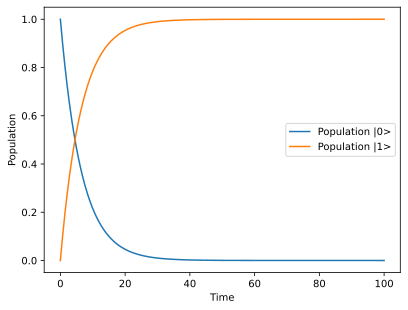

In [604]:
for i, pop in enumerate(result_nodrive.expect):
    plt.plot(times, pop, label=f'Population |{i}>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

## Process Op testing

In [605]:
# Get the charge operator in the native (harmonic oscillator) basis
n_op_native = fluxonium.n_operator()

# n_op_native

In [606]:
n_op_qutip_native = qt.Qobj(n_op_native)

n_op_qutip_native

Quantum object: dims=[[110], [110]], shape=(110, 110), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.+0.j    -0.-0.281j  0.+0.j    ...  0.+0.j     0.+0.j     0.+0.j   ]
 [ 0.+0.281j  0.+0.j    -0.-0.398j ...  0.+0.j     0.+0.j     0.+0.j   ]
 [ 0.+0.j     0.+0.398j  0.+0.j    ...  0.+0.j     0.+0.j     0.+0.j   ]
 ...
 [ 0.+0.j     0.+0.j     0.+0.j    ...  0.+0.j    -0.-2.922j  0.+0.j   ]
 [ 0.+0.j     0.+0.j     0.+0.j    ...  0.+2.922j  0.+0.j    -0.-2.936j]
 [ 0.+0.j     0.+0.j     0.+0.j    ...  0.+0.j     0.+2.936j  0.+0.j   ]]

In [607]:
levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)


In [608]:
evals, evecs = fluxonium.eigensys(evals_count=levels)

In [609]:
n_op_energy_basis = fluxonium.process_op(n_op_native, energy_esys=(evals, evecs))

n_op_energy_basis

array([[0.-0.j   , 0.-0.057j, 0.-0.456j, 0.-0.183j, 0.+0.11j , 0.-0.028j],
       [0.+0.057j, 0.-0.j   , 0.+0.264j, 0.-0.365j, 0.+0.154j, 0.+0.162j],
       [0.+0.456j, 0.-0.264j, 0.+0.j   , 0.+0.403j, 0.-0.043j, 0.+0.233j],
       [0.+0.183j, 0.+0.365j, 0.-0.403j, 0.+0.j   , 0.+0.205j, 0.+0.486j],
       [0.-0.11j , 0.-0.154j, 0.+0.043j, 0.-0.205j, 0.+0.j   , 0.-0.483j],
       [0.+0.028j, 0.-0.162j, 0.-0.233j, 0.-0.486j, 0.+0.483j, 0.-0.j   ]])

In [610]:
# Convert the matrix to a QuTiP Qobj for further analysis
n_op_qutip = qt.Qobj(n_op_energy_basis)

n_op_qutip

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-0.j    0.-0.057j 0.-0.456j 0.-0.183j 0.+0.11j  0.-0.028j]
 [0.+0.057j 0.-0.j    0.+0.264j 0.-0.365j 0.+0.154j 0.+0.162j]
 [0.+0.456j 0.-0.264j 0.+0.j    0.+0.403j 0.-0.043j 0.+0.233j]
 [0.+0.183j 0.+0.365j 0.-0.403j 0.+0.j    0.+0.205j 0.+0.486j]
 [0.-0.11j  0.-0.154j 0.+0.043j 0.-0.205j 0.+0.j    0.-0.483j]
 [0.+0.028j 0.-0.162j 0.-0.233j 0.-0.486j 0.+0.483j 0.-0.j   ]]

## Multi-dimensionality test

In [611]:
evals4, evecs4 = fluxonium.eigensys(evals_count=4)

n_op_flux = fluxonium.n_operator()
n_op_energy = qt.Qobj(evecs4.conj().T @ n_op_flux @ evecs4) # energy basis conversion

print(n_op_energy.shape) 

(4, 4)


In [612]:
H0 = qt.Qobj(np.diag(evals4))

A = 0.1 # also defined above
drive_op4 = n_op_energy 

omega_d = evals4[1] - evals4[0]
H = [H0, [A * drive_op4, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op4

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+0.j    0.-0.057j 0.-0.456j 0.-0.183j]
 [0.+0.057j 0.+0.j    0.+0.264j 0.-0.365j]
 [0.+0.456j 0.-0.264j 0.+0.j    0.+0.403j]
 [0.+0.183j 0.+0.365j 0.-0.403j 0.+0.j   ]]

In [613]:
psi_initial4 = qt.basis(4, 0)

psi_initial4

Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [614]:
proj_04 = qt.basis(4, 0) * qt.basis(4, 0).dag()
proj_14 = qt.basis(4, 1) * qt.basis(4, 1).dag()
proj_24 = qt.basis(4, 2) * qt.basis(4, 2).dag()
proj_34 = qt.basis(4, 3) * qt.basis(4, 3).dag()

proj_24

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [615]:
times = np.linspace(0, 1000, 1000) # time points for the simulation


result_4dim = qt.mesolve(
    H, psi_initial4, times, [],
    [proj_04, proj_14, proj_24, proj_34],
    args=args, options=options
)

result_4dim

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 0.42400026321411133
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 1000.0] (1000 steps)
  Number of e_ops: 4
  States saved.
>

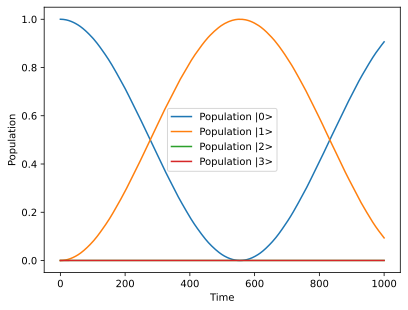

In [616]:
plt.plot(times, result_4dim.expect[0], label='Population |0>')
plt.plot(times, result_4dim.expect[1], label='Population |1>')
plt.plot(times, result_4dim.expect[2], label='Population |2>')
plt.plot(times, result_4dim.expect[3], label='Population |3>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

## Multi-state testing with noise

In [617]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 110) #default tutorial parameters

fluxonium

Fluxonium(**{'EJ': 8.9, 'EC': 2.5, 'EL': 0.5, 'flux': 0.33, 'cutoff': 110, 'truncated_dim': 6, 'id_str': 'Fluxonium_20', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})

In [618]:
levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_flux = fluxonium.n_operator()
n_op_energy = qt.Qobj(evecs.conj().T @ n_op_flux @ evecs) # energy basis conversion

print(n_op_energy.shape) 

(6, 6)


In [619]:
#redefine the n_op_energy_basis

n_op_energy_basis = fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs))

n_op_energy_basis = qt.Qobj(n_op_energy_basis)


In [620]:
H0 = qt.Qobj(np.diag(evals))

A = 0.1 # also defined above
drive_op = n_op_energy_basis
# drive_op = n_op_energy   # this is the one that works  
omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-0.j    0.-0.057j 0.-0.456j 0.-0.183j 0.+0.11j  0.-0.028j]
 [0.+0.057j 0.-0.j    0.+0.264j 0.-0.365j 0.+0.154j 0.+0.162j]
 [0.+0.456j 0.-0.264j 0.+0.j    0.+0.403j 0.-0.043j 0.+0.233j]
 [0.+0.183j 0.+0.365j 0.-0.403j 0.+0.j    0.+0.205j 0.+0.486j]
 [0.-0.11j  0.-0.154j 0.+0.043j 0.-0.205j 0.+0.j    0.-0.483j]
 [0.+0.028j 0.-0.162j 0.-0.233j 0.-0.486j 0.+0.483j 0.-0.j   ]]

In [621]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [622]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

In [623]:
times = np.linspace(0, 3000, 10000)


result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 1.8992962837219238
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 3000.0] (10000 steps)
  Number of e_ops: 6
  States saved.
>

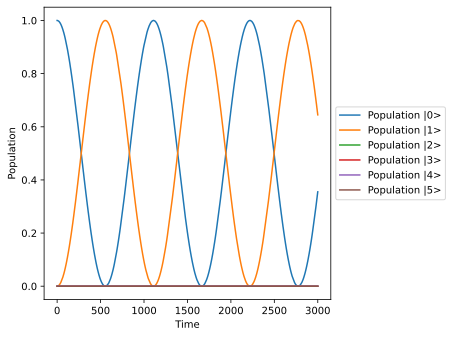

In [624]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

### Adding in Noise

In [625]:
T1 = fluxonium.t1_capacitive(levels, levels-1)
print(f"T1: {T1:.2f} µs")

T1: 14446.07 µs


In [626]:
scq.get_units()

'GHz'

In [627]:
gamma = fluxonium.t1_capacitive(levels, levels-1, get_rate=True)

print(f"Gamma: {gamma:.4f} GHz")

c_ops = []
for n in range(1, levels):
    op = np.sqrt(gamma) * qt.basis(levels, n-1) * qt.basis(levels, n).dag()
    c_ops.append(op)

result_noise = qt.mesolve(H, psi_initial, times, c_ops, projectors, args=args)

Gamma: 0.0001 GHz


 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

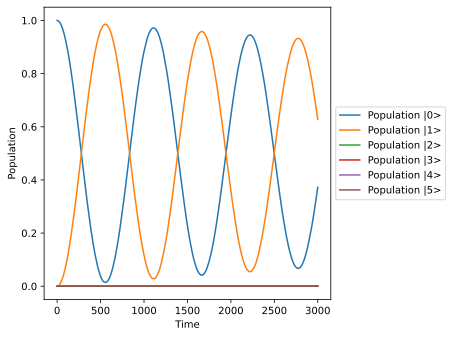

In [628]:
for i in range(levels):
    plt.plot(times, result_noise.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

### Obtaining the propagator

In [629]:
t = 10.0

U = qt.propagator(H, t, args=args)

U

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.004-1.j     0.001+0.028j  0.006+0.004j  0.   +0.j    -0.   -0.j
   0.   -0.j   ]
 [ 0.018-0.021j  0.644-0.764j -0.005-0.006j  0.001+0.004j  0.   -0.001j
  -0.   -0.j   ]
 [-0.004-0.006j  0.002+0.008j -0.993+0.114j  0.023+0.007j -0.001-0.001j
   0.003+0.003j]
 [ 0.   -0.001j  0.002-0.004j -0.018-0.017j -0.388-0.921j  0.   +0.004j
  -0.001+0.005j]
 [-0.   +0.j    -0.001+0.001j  0.001+0.001j -0.001-0.004j  0.09 -0.996j
   0.002+0.004j]
 [ 0.   +0.j    -0.   +0.j    -0.002-0.004j -0.001-0.005j  0.004-0.002j
   0.434-0.901j]]

Comment down the below cell since it takes a long time when running everything

In [630]:
# options = Options(nsteps=100000)  # or even higher if needed

# times_test = np.linspace(0, 1000, 1000) # needed to be short enough my computer could handle it

# Us = [qt.propagator(H, t, args=args, options=options) for t in times_test]

### Truncating time to realize an X gate

In [631]:
d01 = abs(n_op_energy[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

554.7945810895404

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

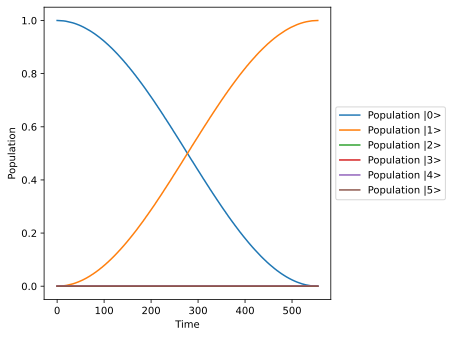

In [632]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

### Average Gate Fidelity

In [633]:
options = Options(nsteps=100000)  # or even higher if needed

U = qt.propagator(H, tx, args=args, options=options)

U


 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.   +0.003j  0.974+0.228j  0.002-0.006j -0.001+0.004j  0.   -0.001j
   0.   -0.001j]
 [-0.623+0.782j -0.002-0.002j -0.006-0.001j -0.002+0.001j  0.001+0.001j
   0.   -0.j   ]
 [-0.003+0.005j -0.   -0.007j  0.997+0.048j  0.032-0.054j  0.   +0.j
  -0.003-0.006j]
 [ 0.002-0.001j  0.   -0.004j  0.028+0.056j -0.997-0.024j  0.004-0.01j
   0.007+0.015j]
 [-0.001-0.001j -0.001-0.j    -0.   -0.j     0.01 +0.003j  0.623-0.78j
   0.002+0.006j]
 [-0.   -0.j    -0.001+0.j    -0.006+0.001j -0.017+0.001j  0.003-0.005j
  -0.466-0.881j]]

In [634]:
options = Options(nsteps=10000000)  # or even higher if needed

times_test = np.linspace(0, 1000, 100) # needed to be short enough my computer could handle it

Us = [qt.propagator(H, t, args=args, options=options) for t in times_test]

In [635]:
X_ideal = qt.qeye(levels)
X_ideal = X_ideal.full()

X_ideal[0, 0] = 0
X_ideal[1, 1] = 0
X_ideal[0, 1] = 1
X_ideal[1, 0] = 1

X_ideal = qt.Qobj(X_ideal)

In [636]:
X_ideal

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [641]:
fidelity = qt.fidelity(U, X_ideal)

print("State gate fidelity:", fidelity)

fidelity = qt.average_gate_fidelity(U, X_ideal)

print("Average gate fidelity:", fidelity)

State gate fidelity: 2.8935967602694888
Average gate fidelity: 0.15834512627695285


In [638]:
Us[56]


Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.03 +0.008j  0.989+0.144j -0.004-0.006j -0.001+0.002j -0.001-0.002j
   0.   -0.001j]
 [ 0.977+0.213j -0.031-0.003j  0.003+0.007j  0.   -0.003j -0.001-0.001j
   0.   -0.001j]
 [-0.003-0.006j  0.003+0.007j -0.448+0.892j  0.03 +0.055j  0.   -0.j
   0.008-0.004j]
 [-0.001+0.002j  0.001-0.002j  0.027+0.057j -0.984-0.16j   0.004-0.003j
   0.002+0.j   ]
 [-0.   -0.002j -0.001-0.001j -0.   -0.j     0.004-0.002j  0.255-0.965j
   0.013+0.026j]
 [ 0.   -0.001j  0.   -0.001j  0.009-0.003j  0.002+0.j     0.012+0.027j
   0.913+0.397j]]

In [639]:
U_matrix = Us[56].full() 

squared_magnitude = np.real(U_matrix)**2 + np.imag(U_matrix)**2

squared_qobj = qt.Qobj(squared_magnitude)

squared_qobj

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.001 0.999 0.    0.    0.    0.   ]
 [0.999 0.001 0.    0.    0.    0.   ]
 [0.    0.    0.996 0.004 0.    0.   ]
 [0.    0.    0.004 0.994 0.    0.   ]
 [0.    0.    0.    0.    0.997 0.001]
 [0.    0.    0.    0.    0.001 0.992]]

In [640]:
# Print the squared magnitude array to 3 decimal points
np.set_printoptions(precision=3, suppress=True)
print(squared_magnitude)

[[0.001 0.999 0.    0.    0.    0.   ]
 [0.999 0.001 0.    0.    0.    0.   ]
 [0.    0.    0.996 0.004 0.    0.   ]
 [0.    0.    0.004 0.994 0.    0.   ]
 [0.    0.    0.    0.    0.997 0.001]
 [0.    0.    0.    0.    0.001 0.992]]
